# Lahman Baseball Dataset - Since 1871


**Notebook Authors:** Brian Clare, Nick Berger & Abhijeet Gunadekar

**Data Source:** Dataset was downloaded from http://www.seanlahman.com/baseball-archive/statistics/

This dataset includes a wide array of baseball statistics including hitting, fielding and pitching data for individual players and teams starting in 1871 and continues to be updated into present day.  Additional data such as salaries, awards, all-star appearances, colleges and team information are included, and spread across several csv files.  For this exploratory data analysis, the Teams.csv dataset will be the main focus.  This set provides us with basic team info and statistics summed up over the designated year.  The table below highlights and describes the data items that we will explore in this notebook.  

**Columns used in this Dataset**


| Column Name | Description | Type |
|---|---|---|
| yearID | Year of season's stats | Integer |
| lgID | League the team plays in (National or American) | String |
| W | Number of games won in the season | Integer |
| L | Number of games lost in the season | Integer |
| R | Total number of runs scored in the season | Integer |
| AB | Total number of at-bats in the season | Integer | 
| H | Total number of hits in the season | Integer |
| HR | Total number of homeruns in the season | Integer |
| BB | Total number of walks in the season (offensive) | Integer |
| SO | Total number of strikeouts in the season (offensive) | Integer |
| SB | Total number of stolen bases in the season | Integer |
| name | Team's name (city & nickname) | String |
| park | Name of team's home field | String |
| attendance | Total attendance in the season | Integer |

## Objectives of this analysis:
* Predict attendance based on seasonal statistics 
* Predict playoff appearance based on team statistics
* Estimate the effect of the Designated Hitter (DH) rule

# Exploratory Data Analysis (EDA)

### Import libraries we will be utilizing & install packages
Pandas and matplotlib will assist us in data visualization later on.

In [4]:
!conda install pandas
!conda install seaborn

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from pyspark.sql.functions import stddev
from pyspark.sql.functions import corr, expr
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula
plt.style.use('ggplot')

### Loading the data into a Spark DataFrame
We will infer the schema and print it to ensure it is infered correctly.

In [6]:
teams = spark.read.load("gs://is843-baseball-multi/Data/Teams.csv",
                     format="csv", sep=",", inferSchema="true", header="true")

In [7]:
teams.printSchema()

root
 |-- yearID: integer (nullable = true)
 |-- lgID: string (nullable = true)
 |-- teamID: string (nullable = true)
 |-- franchID: string (nullable = true)
 |-- divID: string (nullable = true)
 |-- Rank: integer (nullable = true)
 |-- G: integer (nullable = true)
 |-- Ghome: integer (nullable = true)
 |-- W: integer (nullable = true)
 |-- L: integer (nullable = true)
 |-- DivWin: string (nullable = true)
 |-- WCWin: string (nullable = true)
 |-- LgWin: string (nullable = true)
 |-- WSWin: string (nullable = true)
 |-- R: integer (nullable = true)
 |-- AB: integer (nullable = true)
 |-- H: integer (nullable = true)
 |-- 2B: integer (nullable = true)
 |-- 3B: integer (nullable = true)
 |-- HR: integer (nullable = true)
 |-- BB: double (nullable = true)
 |-- SO: integer (nullable = true)
 |-- SB: double (nullable = true)
 |-- CS: double (nullable = true)
 |-- HBP: double (nullable = true)
 |-- SF: integer (nullable = true)
 |-- RA: integer (nullable = true)
 |-- ER: integer (nullable = 

Count the number of rows in the dataset to determine the number of records contained in the Teams.csv file.

In [8]:
print(" The teams DataFrame has {} records".format(teams.count()))

 The teams DataFrame has 2895 records


### Filter the dataset 
* For consistency, the data will be filtered to data from the year 1962 and newer because the 1962 season was when the current 162 game season was implemented.
* We will select only the columns we intend to work with, and store the results back into the teams DataFrame, dropping all unwanted columns.

In [9]:
teams_full = teams.filter(teams['yearID'] >= 1962)\
.filter((teams['yearID'] != 1972) & (teams['yearID'] != 1981) & (teams['yearID'] != 1994) & (teams['yearID'] != 1995))\
.select('yearID', 'lgID', 'W', 'L', 'R', 'AB', 'H', 'HR', 'SO', 'BB', 'SB', 'RA', 'name', 'park', 'attendance', 'DivWin', 'WCWin', 'WSWin')

In [10]:
teams = teams.filter(teams['yearID'] >= 1962)\
.filter((teams['yearID'] != 1972) & (teams['yearID'] != 1981) & (teams['yearID'] != 1994) & (teams['yearID'] != 1995))\
.select('yearID', 'lgID', 'W', 'L', 'R', 'AB', 'H', 'HR', 'SO', 'BB', 'SB', 'RA', 'name', 'attendance')
teams.show(10)

+------+----+---+---+---+----+----+---+----+-----+----+---+--------------------+----------+
|yearID|lgID|  W|  L|  R|  AB|   H| HR|  SO|   BB|  SB| RA|                name|attendance|
+------+----+---+---+---+----+----+---+----+-----+----+---+--------------------+----------+
|  1962|  AL| 77| 85|652|5491|1363|156| 931|516.0|45.0|680|   Baltimore Orioles|    790254|
|  1962|  AL| 76| 84|707|5530|1429|146| 923|525.0|39.0|756|      Boston Red Sox|    733080|
|  1962|  AL| 85| 77|707|5514|1415| 92| 674|620.0|76.0|658|   Chicago White Sox|   1131562|
|  1962|  NL| 59|103|632|5534|1398|126|1044|504.0|78.0|827|        Chicago Cubs|    609802|
|  1962|  NL| 98| 64|802|5645|1523|167| 903|498.0|66.0|685|     Cincinnati Reds|    982095|
|  1962|  AL| 80| 82|682|5484|1341|180| 939|502.0|35.0|745|   Cleveland Indians|    716076|
|  1962|  AL| 85| 76|758|5456|1352|209| 894|651.0|69.0|692|      Detroit Tigers|   1207881|
|  1962|  NL| 64| 96|592|5558|1370|105| 806|493.0|42.0|717|  Houston Colt .45's|

Store the filtered teams DataFrame in cache for quicker access and processing.

In [11]:
teams.cache()

DataFrame[yearID: int, lgID: string, W: int, L: int, R: int, AB: int, H: int, HR: int, SO: int, BB: double, SB: double, RA: int, name: string, attendance: int]

### Examining Yearly Totals
The yearly_correls groups the original teams dataset by yearID and calculates the correlations between the data of interest over that particular year

In [9]:


yearly_correls = teams.groupBy("yearID").agg(expr("corr(RA, W)"), expr("corr(R, W)"), \
                                             expr("corr(W, attendance)"), expr("corr(HR, attendance)"), \
                                             expr("corr(R, attendance)")).orderBy("yearID")

* Send the yearly_correls Spark DataFrame to a Pandas Dataframe for plotting purposes.
* Set the index to the yearID and print out the indices to ensure it's on a yearly basis.

In [10]:
py_yearly_correls = yearly_correls.toPandas()
yearly_correls_df = py_yearly_correls.set_index('yearID')
yearly_correls_df.index

Int64Index([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1973,
            1974, 1975, 1976, 1977, 1978, 1979, 1980, 1982, 1983, 1984, 1985,
            1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1996, 1997, 1998,
            1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
            2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='yearID')

### Yearly Correlation Plots

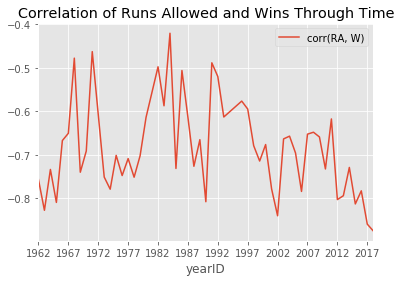

In [11]:
yearly_correls_df[["corr(RA, W)"]].plot.line()
plt.title('Correlation of Runs Allowed and Wins Through Time')
plt.xticks(np.arange(min(yearly_correls_df.index), max(yearly_correls_df.index), step = 5));

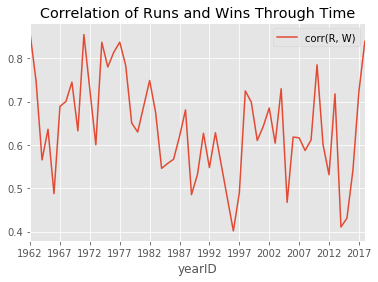

In [12]:
yearly_correls_df[["corr(R, W)"]].plot.line()
plt.title('Correlation of Runs and Wins Through Time')
plt.xticks(np.arange(min(yearly_correls_df.index), max(yearly_correls_df.index), step = 5));

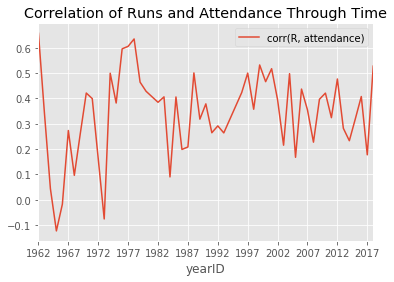

In [13]:
yearly_correls_df[["corr(R, attendance)"]].plot.line()
plt.title('Correlation of Runs and Attendance Through Time')
plt.xticks(np.arange(min(yearly_correls_df.index), max(yearly_correls_df.index), step = 5));

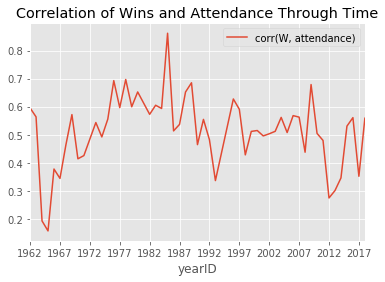

In [14]:
yearly_correls_df[["corr(W, attendance)"]].plot.line()
plt.title('Correlation of Wins and Attendance Through Time')
plt.xticks(np.arange(min(yearly_correls_df.index), max(yearly_correls_df.index), step = 5));

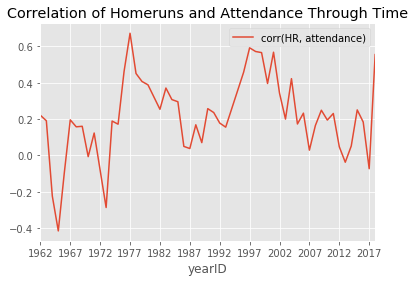

In [15]:
yearly_correls_df[["corr(HR, attendance)"]].plot.line()
plt.title('Correlation of Homeruns and Attendance Through Time')
plt.xticks(np.arange(min(yearly_correls_df.index), max(yearly_correls_df.index), step = 5));

### Yearly Averages DataFrame
This data focuses on some key metrics, but groups the data by year and calculates the average statistics over each year.  By taking the average over each year, we can understand the correlations between the statistics for the entire set from 1962 on, rather than just the evolutions of correlations on a yearly basis.

In [16]:
by_year = teams.groupBy('yearID').avg('HR', 'R', 'SO', 'BB', 'RA', 'attendance').orderBy('yearID')
by_year.show()

+------+------------------+-----------------+-----------------+------------------+-----------------+------------------+
|yearID|           avg(HR)|           avg(R)|          avg(SO)|           avg(BB)|          avg(RA)|   avg(attendance)|
+------+------------------+-----------------+-----------------+------------------+-----------------+------------------+
|  1962|            150.05|           723.05|           878.35|             546.8|           723.05|        1068760.75|
|  1963|             135.2|            639.0|           938.65|            479.55|            639.0|         1023853.7|
|  1964|             138.1|            656.2|            960.6|            481.05|            656.2|        1064017.05|
|  1965|             134.4|            647.3|           964.15|             501.8|            647.3|         1122095.0|
|  1966|            137.15|            645.0|           940.25|            466.55|            645.0|        1259110.45|
|  1967|            114.95|            6

Use the describe method to give a brief overview of the yearly average DataFrame.

In [17]:
by_year.describe(['avg(HR)', 'avg(R)', 'avg(SO)', 'avg(BB)', 'avg(RA)', 'avg(attendance)']).show()

+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|          avg(HR)|           avg(R)|           avg(SO)|          avg(BB)|          avg(RA)|   avg(attendance)|
+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|  count|               53|               53|                53|               53|               53|                53|
|   mean|146.9655072914507|708.7127617665352| 993.0900425046651|525.1955594719744|708.7127617665352|1931272.0041398853|
| stddev|26.21198648021083|55.87876317349642|150.88306796344258|31.51419701083432|55.87876317349642| 534303.4403772076|
|    min|           93.125|           555.45| 770.5769230769231|            457.8|           555.45|         1023853.7|
|    max|            203.5|832.3666666666667|1373.5666666666666|            607.9|832.3666666666667|         2649490.6|
+-------+-----------------+-------------

Similar to above, send the Spark DataFrame to a Pandas DataFrame for plotting.

In [18]:
py_by_year = by_year.toPandas()
df = py_by_year.set_index('yearID')

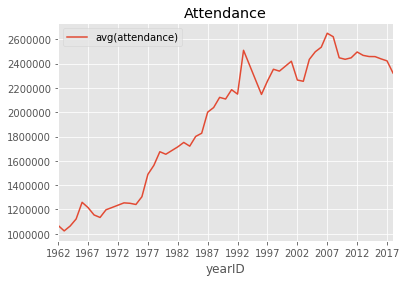

In [19]:
df[["avg(attendance)"]].plot.line()
plt.title('Attendance')
plt.xticks(np.arange(min(df.index), max(df.index), step = 5));

It is noted that in general, the attendance has increased steadily over time until the late 2000s, where it has begun to trend downward.  This is part of what we will investigate going forward in this project.

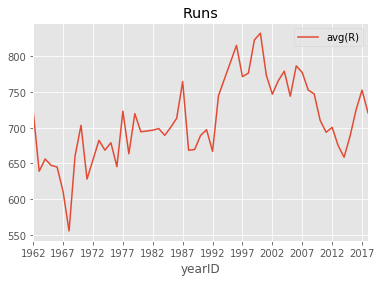

In [20]:
df[["avg(R)"]].plot.line()
plt.title('Runs')
plt.xticks(np.arange(min(df.index), max(df.index), step = 5));

In the 1990's, there was a boom in scoring that can likely be attributed to a combination of expansion teams and the use of PEDs.  Since the league has started to crack down on the usage of PEDs, the scoring has returned to typical levels.

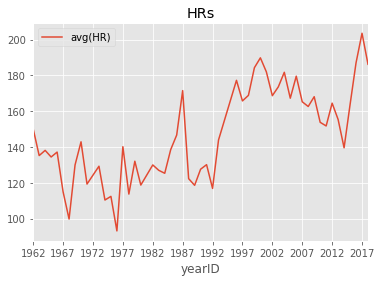

In [21]:
df[["avg(HR)"]].plot.line()
plt.title('HRs')
plt.xticks(np.arange(min(df.index), max(df.index), step = 5));

Homeruns followed a similar trend to the runs scored up until the last few years.  The recent spike in homeruns can be attributed to new teaching philosophy that emphasizes hitting the ball at optimal angle to produce homeruns.

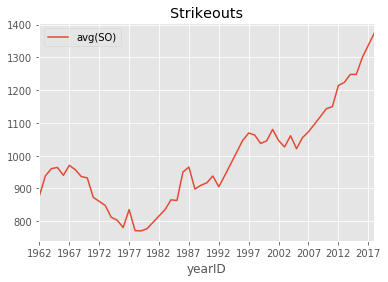

In [22]:
df[["avg(SO)"]].plot.line()
plt.title('Strikeouts')
plt.xticks(np.arange(min(df.index), max(df.index), step = 5));

This plot shows a clear trend signifying an increase in strikeouts over the last 15 years, potentially due to new hitting philosophy and approach mentioned above.  The new approach is more accepting of strikeouts, due to the increase in homeruns and extra base hits.

### MLB Era Investigation

The strike in 1994 changed the shape of baseball with the addition of expansion teams, long time off from playing and increased popularity in using performance enhancing drugs (PEDs).  Due to this reason, we decided to break up the data into pre 1994 and post 1994 to assess the impacts.  Additionally, we created a DataFrame for the last 15 years to consider trends in only recent data.

In [23]:
old_days = teams.filter(teams['yearID'] <= 1994)
new_days = teams.filter(teams['yearID'] > 1994)
very_recent = teams.filter(teams['yearID'] > 2004)

The following correlations will give us insight on the relationship between statistics over the timeframes specified above.  This will act as summary data of the plots in the prior section over these time periods. 

In [24]:
print(old_days.stat.corr('RA', 'W'), new_days.stat.corr('RA', 'W'), very_recent.stat.corr('RA', 'W'))

-0.5747094310121827 -0.6248209421833527 -0.6706762538433608


In [25]:
print(old_days.stat.corr('R', 'W'), new_days.stat.corr('R', 'W'), very_recent.stat.corr('R', 'W'))

0.5882207679274264 0.5255592976564906 0.5413647515184377


In [26]:
print(old_days.stat.corr('W', 'attendance'), new_days.stat.corr('W', 'attendance'), \
      very_recent.stat.corr('W', 'attendance'))

0.4281846538252815 0.4856952251980571 0.471955109178026


In [27]:
print(old_days.stat.corr('HR', 'attendance'), new_days.stat.corr('HR', 'attendance'), \
      very_recent.stat.corr('HR', 'attendance'))

0.19059918764133732 0.251909742675173 0.13783317911545864


In [28]:
print(old_days.stat.corr('R', 'attendance'), new_days.stat.corr('R', 'attendance'), \
      very_recent.stat.corr('R', 'attendance'))

0.38755846349886097 0.2937024286147525 0.3232584217096827


Each of the correlations shown above seem to be steady over time, so we will not be using the split data for analysis moving forward.

## Predicting Playoffs

In [29]:
teams_playoff = teams_full.filter(teams['yearID'] >= 1995)\
.select('yearID', 'lgID', 'DivWin', 'WCWin', 'WSWin', 'R', 'H', 'HR', 'SO', 'BB', 'SB', 'RA')
teams_playoff.show(10)

+------+----+------+-----+-----+---+----+---+----+-----+-----+----+
|yearID|lgID|DivWin|WCWin|WSWin|  R|   H| HR|  SO|   BB|   SB|  RA|
+------+----+------+-----+-----+---+----+---+----+-----+-----+----+
|  1996|  NL|     Y|    N|    N|773|1514|197|1032|530.0| 83.0| 648|
|  1996|  AL|     N|    Y|    N|949|1557|257| 915|645.0| 76.0| 903|
|  1996|  AL|     N|    N|    N|928|1631|209|1020|642.0| 91.0| 921|
|  1996|  AL|     N|    N|    N|762|1571|192| 974|527.0| 53.0| 943|
|  1996|  AL|     N|    N|    N|898|1586|195| 927|701.0|105.0| 794|
|  1996|  NL|     N|    N|    N|772|1388|175|1090|523.0|108.0| 771|
|  1996|  NL|     N|    N|    N|778|1398|191|1134|604.0|171.0| 773|
|  1996|  AL|     Y|    N|    N|952|1665|218| 844|671.0|160.0| 769|
|  1996|  NL|     N|    N|    N|961|1607|221|1108|527.0|201.0| 964|
|  1996|  AL|     N|    N|    N|783|1413|204|1268|546.0| 87.0|1103|
+------+----+------+-----+-----+---+----+---+----+-----+-----+----+
only showing top 10 rows



In [30]:
teams_playoff.cache()

DataFrame[yearID: int, lgID: string, DivWin: string, WCWin: string, WSWin: string, R: int, H: int, HR: int, SO: int, BB: double, SB: double, RA: int]

### Feature Design & Target Preparation 
* The "lgID" field will be included, but must be changed into numerical format to be included in the Logistic Regression.  The National League (NL) will be represented by a value of 0, and the American League (AL) will be represented by a value of 1.
* In order to perform the logic explained below to create the target column, we must make "Y" values equal to 1, and "N" values equal to 0.
* A new column will be created holding the logical value of the "DivWin" column OR the "WCWin column.  This will represent whether or not the team made it to the playoffs that year, which is out target.

In [32]:
playoffs = teams_playoff.withColumn("lgID", F.when(teams_playoff['lgID'] == 'NL', 0).otherwise(1))\
.withColumn("DivWin", F.when(teams_playoff['DivWin'] == 'Y', 1).otherwise(0))\
.withColumn("WCWin", F.when(teams_playoff['WCWin'] == 'Y', 1).otherwise(0))\
.withColumn("WSWin", F.when(teams_playoff['WSWin'] == 'Y', 1).otherwise(0))

In [33]:
playoffs.withColumn("DivWin", playoffs['DivWin'].cast(IntegerType()))
playoffs.withColumn("WCWin", playoffs['WCWin'].cast(IntegerType()))
playoffs.withColumn("WSWin", playoffs['WSWin'].cast(IntegerType()))

DataFrame[yearID: int, lgID: int, DivWin: int, WCWin: int, WSWin: int, R: int, H: int, HR: int, SO: int, BB: double, SB: double, RA: int]

In [34]:
playoffs_final = playoffs.withColumn("playoffs", playoffs['DivWin'] + playoffs["WCWin"])\
.drop("DivWin", "WCWin")
playoffs_final.show(10)

+------+----+-----+---+----+---+----+-----+-----+----+--------+
|yearID|lgID|WSWin|  R|   H| HR|  SO|   BB|   SB|  RA|playoffs|
+------+----+-----+---+----+---+----+-----+-----+----+--------+
|  1996|   0|    0|773|1514|197|1032|530.0| 83.0| 648|       1|
|  1996|   1|    0|949|1557|257| 915|645.0| 76.0| 903|       1|
|  1996|   1|    0|928|1631|209|1020|642.0| 91.0| 921|       0|
|  1996|   1|    0|762|1571|192| 974|527.0| 53.0| 943|       0|
|  1996|   1|    0|898|1586|195| 927|701.0|105.0| 794|       0|
|  1996|   0|    0|772|1388|175|1090|523.0|108.0| 771|       0|
|  1996|   0|    0|778|1398|191|1134|604.0|171.0| 773|       0|
|  1996|   1|    0|952|1665|218| 844|671.0|160.0| 769|       1|
|  1996|   0|    0|961|1607|221|1108|527.0|201.0| 964|       0|
|  1996|   1|    0|783|1413|204|1268|546.0| 87.0|1103|       0|
+------+----+-----+---+----+---+----+-----+-----+----+--------+
only showing top 10 rows



Calculate the means and standard deviations of the numerical feature columns so that they can be used to scale the data relative to the year.  This will remove trends such as increased scoring over time.

In [35]:
playoffs_means = playoffs_final.groupBy('yearID').mean('R', 'H', 'HR', 'SO', 'BB', 'SB', 'RA').sort('yearID')

In [36]:
playoffs_SDs = playoffs_final.groupBy('yearID').agg(stddev('R'), stddev('H'), stddev('HR'),
                                        stddev('SO'), stddev('BB'), stddev('SB'), stddev('RA')).sort('yearID')

In [37]:
playoffs_joinDF = playoffs_final.join(playoffs_means, 'yearID')
playoffs_joinDF = playoffs_joinDF.join(playoffs_SDs, 'yearID')

In [113]:
scaled_playoffs = playoffs_joinDF.withColumn('H', (playoffs_joinDF['H'] - playoffs_joinDF['avg(H)'])\
                                             / playoffs_joinDF['stddev_samp(H)'])
scaled_playoffs = scaled_playoffs.withColumn('R', (playoffs_joinDF['R'] - playoffs_joinDF['avg(R)'])\
                                             / playoffs_joinDF['stddev_samp(R)'])
scaled_playoffs = scaled_playoffs.withColumn('HR', (playoffs_joinDF['HR'] - playoffs_joinDF['avg(HR)'])\
                                             / playoffs_joinDF['stddev_samp(HR)'])
scaled_playoffs = scaled_playoffs.withColumn('SO', (playoffs_joinDF['SO'] - playoffs_joinDF['avg(SO)'])\
                                             / playoffs_joinDF['stddev_samp(SO)'])
scaled_playoffs = scaled_playoffs.withColumn('BB', (playoffs_joinDF['BB'] - playoffs_joinDF['avg(BB)'])\
                                             / playoffs_joinDF['stddev_samp(BB)'])
scaled_playoffs = scaled_playoffs.withColumn('SB', (playoffs_joinDF['SB'] - playoffs_joinDF['avg(SB)'])\
                                             / playoffs_joinDF['stddev_samp(SB)'])
scaled_playoffs = scaled_playoffs.withColumn('RA', (playoffs_joinDF['RA'] - playoffs_joinDF['avg(RA)'])\
                                             / playoffs_joinDF['stddev_samp(RA)'])

scaled_playoffs = scaled_playoffs.select('yearID', 'lgID', 'H', 'R', 'HR', 'SO', 'BB', 'SB', 'RA', 'playoffs', 'WSWin')

In [114]:
playoffs_runs_only = scaled_playoffs.select('yearID', 'R', 'RA', 'playoffs', 'WSWin')

Split the data into test and train so that the train data can be used to fit the model, and the test data to evaluate the model performance.

In [115]:
pipeline_train_playoffs, pipeline_test_playoffs = scaled_playoffs.randomSplit([0.7, 0.3], seed = 843)
pipeline_train_runsOnly, pipeline_test_runsOnly = playoffs_runs_only.randomSplit([0.7, 0.3], seed = 843)

* Define the Logistic Regression label and feature columns, as well as the threshold we will use to distinguish between the prediction being 1 or 0 for the target variable.
* Instantiate a blank RFormula to be used in the Pipeline.  The hyperparameter grid will populate the RFormula arguments with the few combinations we want to try.
* Define the pipeline with stages of RFormula and Logistic Regression to be applied to the hyperparameter grid.

In [116]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula

rFormPlayoffs = RFormula()
lr_playoffs = LogisticRegression().setLabelCol("label").setFeaturesCol("features").setThreshold(0.4)

stages_playoffs = [rFormPlayoffs, lr_playoffs]  # setting the stages
pipeline_playoffs = Pipeline().setStages(stages_playoffs)  # adding the stages to the pipeline

* Define the hyperparameter grid where we will experiment with differing RFormulas, elasticNetParams & regParams.
* We will choose areaUnderROC as the evaluation metric
* Set a Training and Validation split, while specifying the Estimator Param Maps, Estimator & Evaluator.

In [117]:
# building the hyperparameter grid
params_playoffs = ParamGridBuilder()\
  .addGrid(rFormPlayoffs.formula, [
    "playoffs ~ . - WSWin - yearID - lgID",
    "playoffs ~ . - WSWin - yearID - lgID + R : RA",
    "playoffs ~ . - WSWin - yearID - lgID - SO + R : HR",
    "playoffs ~ . - WSWin - yearID - lgID - SO + R : RA + R : HR"])\
  .addGrid(lr_playoffs.elasticNetParam, [0.0, 0.25, 0.5])\
  .addGrid(lr_playoffs.regParam, [0.0, 0.15, 0.3])\
  .build()

params_runsOnly = ParamGridBuilder()\
  .addGrid(rFormPlayoffs.formula, [
    "playoffs ~ . - WSWin - yearID - lgID",
    "playoffs ~ . - WSWin - yearID - lgID + R : RA"])\
  .addGrid(lr_playoffs.elasticNetParam, [0.0, 0.25, 0.5])\
  .addGrid(lr_playoffs.regParam, [0.0, 0.15, 0.3])\
  .build()

# setting the evaluator as AUC
evaluator_playoffs = BinaryClassificationEvaluator(metricName='areaUnderROC')

# defining Train Validation Split to be used for hypyerparameter tuning
tvs_playoffs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params_playoffs)\
  .setEstimator(pipeline_playoffs)\
  .setEvaluator(evaluator_playoffs)

tvs_runsOnly = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params_runsOnly)\
  .setEstimator(pipeline_playoffs)\
  .setEvaluator(evaluator_playoffs)

Below we will fit the model with our training dataset and then transform the test dataset by running it through our model defined above.

In [118]:
tvsFitted_playoffs = tvs_playoffs.fit(pipeline_train_playoffs)  # fit the estimator
tvsFitted_runsOnly = tvs_runsOnly.fit(pipeline_train_runsOnly)

playoffs_results = tvsFitted_playoffs.transform(pipeline_test_playoffs)

playoffs_runsOnly_results_train = tvsFitted_runsOnly.transform(pipeline_train_runsOnly)
playoffs_runsOnly_results = tvsFitted_runsOnly.transform(pipeline_test_runsOnly)

The AUC shown below represents the performance of the model including most of the originally defined features. 

In [121]:
bestModel_playoffs = tvsFitted_playoffs.bestModel
evaluator_playoffs.evaluate(playoffs_results)  # evaluate the test set (AUC)

0.9489453499520614

The AUC here is the performance of the model where only Runs (R) and Runs Allowed (RA) are the features.

In [122]:
bestModel_runsOnly = tvsFitted_runsOnly.bestModel
evaluator_playoffs.evaluate(playoffs_runsOnly_results)

0.9436198721913007

This very small difference between the performance of the model with many features and the model with only R and RA shows us that the R and RA are two of the most important features when predicting a playoff berth for a baseball team.

The code below pulls out the name of the features and interactions used in the model and puts them in a DataFrame with their respective coefficient.

In [123]:
featureCols_playoffs = pd.DataFrame(playoffs_results\
                            .schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols_playoffs = featureCols_playoffs.set_index('idx')

coefsArray_playoffs = np.array(bestModel_playoffs.stages[-1].coefficients)  # convert to np.array
coefsPlayoffsDF = pd.DataFrame(coefsArray_playoffs, columns=['coefs'])  # to pandas

coefsPlayoffsDF = coefsPlayoffsDF.merge(featureCols_playoffs, left_index=True, right_index=True) 
coefsPlayoffsDF.sort_values('coefs', inplace=True)  # Sort them
coefsPlayoffsDF

,coefs,name
5,-0.698080,RA
6,-0.176371,R:RA
7,0.043912,R:HR
4,0.044323,SB
2,0.157278,HR
0,0.231791,H
3,0.335532,BB
1,0.390302,R


In [124]:
featureCols_runsOnly = pd.DataFrame(playoffs_runsOnly_results\
                            .schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols_runsOnly = featureCols_runsOnly.set_index('idx')

coefsArray_runsOnly = np.array(bestModel_runsOnly.stages[-1].coefficients)  # convert to np.array
coefsRunsOnlyDF = pd.DataFrame(coefsArray_runsOnly, columns=['coefs'])  # to pandas

coefsRunsOnlyDF = coefsRunsOnlyDF.merge(featureCols_runsOnly, left_index=True, right_index=True) 
coefsRunsOnlyDF.sort_values('coefs', inplace=True)  # Sort them
coefsRunsOnlyDF

,coefs,name
1,-0.643561,RA
2,-0.125494,R:RA
0,0.603053,R


When originally running the Logistic Regression model with the default threshold of 0.5, we noticed that for "playoffs_results", we were only predicting there to be roughly 40 playoff teams.  Based on the split percentage we did between test and split, we expected the number to be 56 playoff teams for the test dataset.  In order to compensate for this we changed the threshold parameter to 0.4, which brought our number of predicted playoff teams closer to the actual.

Note: The number of expected playoff teams has changed because we re-ran the Test / Train split function.

In [125]:
playoffs_results_pd = playoffs_results.select("label", "prediction").toPandas()

In [126]:
pd.crosstab(playoffs_results_pd['label'], playoffs_results_pd['prediction'])

prediction,0.0,1.0
label,,
0.0,137,12
1.0,11,45


We applied the same logic above to the model where we use only Runs and Runs Allowed as the features because we were under-predicting the number of playoff teams here as well.  We changed the threshold to 0.4, but then began to over-predict the number of playoff teams as a result.

In [127]:
playoffs_runsOnly_results_pd = playoffs_runsOnly_results.select("label", "prediction").toPandas()

In [128]:
pd.crosstab(playoffs_runsOnly_results_pd['label'], playoffs_runsOnly_results_pd['prediction'])

prediction,0.0,1.0
label,,
0.0,144,10
1.0,18,45


In the following analysis, we will use the model and datasets with the features of Runs and Runs Allowed, because the model performance was almost exactly the same as the model including many additional offensive statistic features.

### Predicting World Series Winner

Now that we have a model that predicts whether or not a team will make the playoffs, we will use the percentage output by the transform to attempt to predict the team to win the world series each year.  Since the minimum probability represents the best chance of making the playoffs, we will find the minimum probability value for each year after combining the test and train datasets (to ensure completeness & proper join later).  Our strategy is to predict that the team with the best chance of making the playoffs based on their Runs and Runs Allowed statistics, will go on to win the World Series.

In [130]:
runsOnlyCombinedResults = playoffs_runsOnly_results.unionAll(playoffs_runsOnly_results_train)

Grouping by the yearID and aggregating over the probability to find the minimum gives us the team with the best chance to make the playoffs by year.

In [140]:
max_probs = runsOnlyCombinedResults.groupBy("yearID").agg(F.min("probability"))
max_probs = max_probs.withColumn("probability", max_probs['min(probability)']).sort("yearID")
max_probs = max_probs["yearID", "probability"]
max_probs.show(5)

+------+--------------------+
|yearID|         probability|
+------+--------------------+
|  1996|[0.44817754116381...|
|  1997|[0.32960642959814...|
|  1998|[0.19332778879315...|
|  1999|[0.27910844742116...|
|  2000|[0.34844696548504...|
+------+--------------------+
only showing top 5 rows



Assuming that the combination of the yearID and probability being unique in the un-grouped dataset, we will inner join our two DataFrames to assess our prediction method for the World Series winner.

In [141]:
worldSeriesDF = runsOnlyCombinedResults.join(max_probs, how='inner', on=['yearID', 'probability'])
worldSeriesDF = worldSeriesDF.select("yearID", "probability", "WSWin")
worldSeriesDF.show(5)

+------+--------------------+-----+
|yearID|         probability|WSWin|
+------+--------------------+-----+
|  2002|[0.33893915851000...|    1|
|  1997|[0.32960642959814...|    0|
|  2006|[0.31779041263349...|    0|
|  2014|[0.33048708697592...|    0|
|  2000|[0.34844696548504...|    0|
+------+--------------------+-----+
only showing top 5 rows



Now that we have the WSWin column side by side with the probability representing the best chance to make the playoffs by year, we can take the mean of the WSWin column to determine how accurate this method is.

In [142]:
worldSeriesAcc = worldSeriesDF.groupBy().mean('WSWin').collect()[0][0]
worldSeriesAcc

0.17391304347826086

We have found that we can predict the World Series winner by our proposed method 17.4% of the time.  To put this into perspective, a random selection from the pool of known playoff teams under the current rules would yield a 10% success rate, because 10 teams make the playoffs each year.  Even using old Wild Card rules, 8 teams make the playoffs, yielding a 12.5% success rate.

## Predicting Attendance

Attendance is the major driver of revenue for Major League Baseball teams. Knowing what factors will affect attendance is thus very important. We know many off-the-field factors are probably relevant, but for this analysis we are only looking at playing statistics.

In [13]:
df = teams_full.filter(teams_full['yearID'] >= 1962)\
.select('yearID', 'lgID', 'W', 'R', 'H', 'HR', 'SO', 'BB', 'SB', 'attendance', 'park')

Since different stadiums have different seating capacity, we include here the park that the team plays in.

In [16]:
attendance_means = df.groupBy('yearID').mean('R', 'H', 'HR', 'SO', 'BB', 'SB').sort('yearID')
attendance_SDs = df.groupBy('yearID').agg(stddev('R'), stddev('H'), stddev('HR'),
                                        stddev('SO'), stddev('BB'), stddev('SB')).sort('yearID')

attendance_joinDF = df.join(attendance_means, 'yearID')
attendance_joinDF = attendance_joinDF.join(attendance_SDs, 'yearID')

scaled_attendance = attendance_joinDF.withColumn('H', (attendance_joinDF['H'] - attendance_joinDF['avg(H)'])\
                                             / attendance_joinDF['stddev_samp(H)'])
scaled_attendance = scaled_attendance.withColumn('R', (attendance_joinDF['R'] - attendance_joinDF['avg(R)'])\
                                             / attendance_joinDF['stddev_samp(R)'])
scaled_attendance = scaled_attendance.withColumn('HR', (attendance_joinDF['HR'] - attendance_joinDF['avg(HR)'])\
                                             / attendance_joinDF['stddev_samp(HR)'])
scaled_attendance = scaled_attendance.withColumn('SO', (attendance_joinDF['SO'] - attendance_joinDF['avg(SO)'])\
                                             / attendance_joinDF['stddev_samp(SO)'])
scaled_attendance = scaled_attendance.withColumn('BB', (attendance_joinDF['BB'] - attendance_joinDF['avg(BB)'])\
                                             / attendance_joinDF['stddev_samp(BB)'])
scaled_attendance = scaled_attendance.withColumn('SB', (attendance_joinDF['SB'] - attendance_joinDF['avg(SB)'])\
                                             / attendance_joinDF['stddev_samp(SB)'])

scaled_attendance = scaled_attendance.select('yearID', 'lgID', 'W', 'H', 'R', 'HR', 'SO', 'BB', 'SB', 'attendance', 'park')

Similar to the playoff predictions, team statistics are scaled relative to the average statistics for that season. This scaling is not applied to wins, since every season has the same number of games and roughly the same distribution of wins.

In [17]:
teams_maxatt_bypark = df.groupBy('park').max('attendance')

scaled_attendance_park = scaled_attendance.join(teams_maxatt_bypark,'park')
scaled_attendance_park = scaled_attendance_park\
    .withColumn('attendance_scaled',scaled_attendance_park['attendance']/teams_maxatt_bypark['max(attendance)'])
scaled_attendance_park = scaled_attendance_park\
    .select('yearID', 'lgID', 'W', 'H', 'R', 'HR', 'SO', 'BB', 'SB','attendance_scaled')

As mentioned above, not every park has the same capacity. We don't know the exact sizes of each stadium in terms of number of seats, but we can find the maximum annual attendance ever for that park and scale every other season in that park relative to the maximum. In this way, our response variable is the percentage of maximum attendance. It is possible to have a new season with higher than the previous maximum.

In [22]:
supervised = RFormula(formula="attendance_scaled ~ W + H + R + HR + SO + BB + SB")

fittedRF = supervised.fit(scaled_attendance_park) 

preparedDF = fittedRF.transform(scaled_attendance_park)

train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)

We use a simple linear regression with all of the included variables and split into a training and test set.

In [23]:
lr = LinearRegression()

lrModel = lr.fit(train)
prediction = lrModel.transform(test)

In [26]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')

coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head(7)

,coefs,name
3,-0.024128,HR
6,-0.008733,SB
4,-0.002488,SO
1,-0.002380,H
5,0.003229,BB
0,0.006700,W
2,0.025090,R


Here are the coefficients. It's useful to remember that all features except Wins are standardized (ranging from about -3 to 3) and Wins are not (ranging from about 50 to 110).

As you probably would expect, we predict higher attendance for teams that score more runs and win more games. The negative coefficient of HR suggests that fans won't come out to see bad teams even if they hit a lot of home runs.

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(prediction)
print("RMSE: %.3f" % rmse)

# r2 - coefficient of determination
r2 = eval.evaluate(prediction, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

RMSE: 0.203
r2: 0.165
Coefficients: [0.0067001086529672165,-0.002380126770699123,0.025089671295753405,-0.02412845917280498,-0.002487829234738071,0.003228674212020431,-0.008732562992929013]
Intercept: 0.14454641993025089


With an R-squared value of 0.165, that shows the non-baseball factors greatly outweigh baseball statistics in terms of predicting team attendance.

Some of the factors that we would consider investigating for further analysis are weather, ticket prices, stadium condition, team marketing and promotions, player popularity, and availability of other local entertainment.

## American League (AL) vs National League (NL)

Major League Baseball is divided into two leagues: American (AL) and National (NL). During the regular season most games are played within the league, and the league winners face off in the World Series every fall. The AL and NL have most of the same rules, but one significant difference is the Designated Hitter rule in the AL.
In the NL, each of the 9 players takes turns batting, including the pitcher (who is usually not a very good batter). In the AL, teams are allowed to have a designated hitter take the pitcher's place batting. Replacing your weakest hitter with someone whose only job is hitting should have an effect of increasing runs scored and other offensive statistics.

The DH rule was adopted by the AL in 1973, so we have data both before and after the rule was applied.

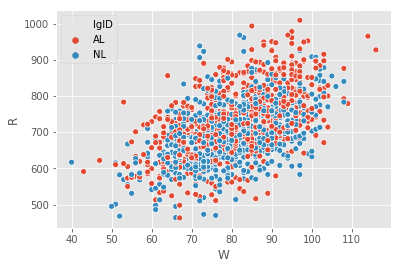

In [41]:
py_teams = teams.select('W', 'R', 'lgID').toPandas()
plot1 = sns.scatterplot(x = py_teams['W'], y = py_teams['R'], hue = py_teams['lgID'])

As we can see, regardless of league there is a strong tendency for winning teams to score more runs. If we want to quantify the impact of the DH rule, we need take that into account.

In [42]:
AL = teams.filter(teams['lgID'] == 'AL')
AL.show(10)

+------+----+---+---+---+----+----+---+---+-----+----+---+--------------------+--------------------+----------+
|yearID|lgID|  W|  L|  R|  AB|   H| HR| SO|   BB|  SB| RA|                name|                park|attendance|
+------+----+---+---+---+----+----+---+---+-----+----+---+--------------------+--------------------+----------+
|  1962|  AL| 77| 85|652|5491|1363|156|931|516.0|45.0|680|   Baltimore Orioles|    Memorial Stadium|    790254|
|  1962|  AL| 76| 84|707|5530|1429|146|923|525.0|39.0|756|      Boston Red Sox|      Fenway Park II|    733080|
|  1962|  AL| 85| 77|707|5514|1415| 92|674|620.0|76.0|658|   Chicago White Sox|       Comiskey Park|   1131562|
|  1962|  AL| 80| 82|682|5484|1341|180|939|502.0|35.0|745|   Cleveland Indians|   Cleveland Stadium|    716076|
|  1962|  AL| 85| 76|758|5456|1352|209|894|651.0|69.0|692|      Detroit Tigers|       Tiger Stadium|   1207881|
|  1962|  AL| 72| 90|745|5576|1467|116|803|556.0|76.0|837|Kansas City Athle...| Municipal Stadium I|    

In [43]:
NL = teams.filter(teams['lgID'] == 'NL')
NL.show(10)

+------+----+---+---+---+----+----+---+----+-----+-----+---+--------------------+-------------------+----------+
|yearID|lgID|  W|  L|  R|  AB|   H| HR|  SO|   BB|   SB| RA|                name|               park|attendance|
+------+----+---+---+---+----+----+---+----+-----+-----+---+--------------------+-------------------+----------+
|  1962|  NL| 59|103|632|5534|1398|126|1044|504.0| 78.0|827|        Chicago Cubs|      Wrigley Field|    609802|
|  1962|  NL| 98| 64|802|5645|1523|167| 903|498.0| 66.0|685|     Cincinnati Reds|      Crosley Field|    982095|
|  1962|  NL| 64| 96|592|5558|1370|105| 806|493.0| 42.0|717|  Houston Colt .45's|       Colt Stadium|    924456|
|  1962|  NL|102| 63|842|5628|1510|140| 886|572.0|198.0|697| Los Angeles Dodgers|     Dodger Stadium|   2755184|
|  1962|  NL| 86| 76|730|5458|1376|181| 975|581.0| 57.0|665|    Milwaukee Braves|     County Stadium|    766921|
|  1962|  NL| 40|120|617|5492|1318|139| 991|616.0| 59.0|948|       New York Mets|    Polo Ground

In [46]:
AL_by_year = AL.groupBy('yearID').avg('H', 'HR', 'R', 'SO', 'BB', 'attendance').orderBy('yearID')

In [47]:
AL_by_year.show(10)

+------+------------------+------------------+-----------------+-----------------+-----------------+------------------+
|yearID|            avg(H)|           avg(HR)|           avg(R)|          avg(SO)|          avg(BB)|   avg(attendance)|
+------+------------------+------------------+-----------------+-----------------+-----------------+------------------+
|  1962|            1406.8|             155.2|            718.3|            853.5|            567.1|         1001505.6|
|  1963|            1360.9|             148.9|            659.9|            922.8|            503.1|          909484.7|
|  1964|            1363.7|             155.1|            660.7|            995.6|            522.7|          923515.1|
|  1965|            1315.8|             137.0|            638.8|            963.4|            530.6|          886076.4|
|  1966|            1300.5|             136.5|            627.6|            949.3|            492.7|         1016673.8|
|  1967|            1276.6|             

In [49]:
py_AL_by_year = AL_by_year.toPandas()

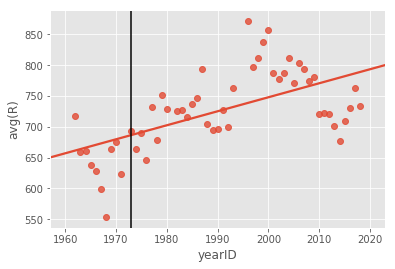

In [50]:
sns.regplot(x = py_AL_by_year['yearID'], y = py_AL_by_year["avg(R)"], ci = None)
plt.axvline(x = 1973, color= 'black')

The AL started using a DH in 1973, which is represented by the vertical line in the plot above.  We can see that scoring seems to have increased, on average, after this time.

In [51]:
NL_by_year = NL.groupBy('yearID').avg('H', 'HR', 'R', 'SO', 'BB', 'attendance').orderBy('yearID')

In [52]:
py_NL_by_year = NL_by_year.toPandas()

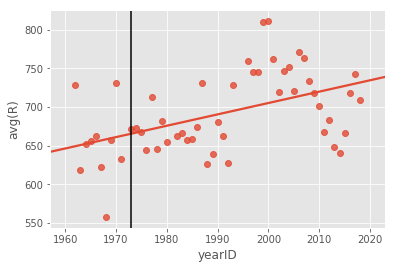

In [53]:
sns.regplot(x = py_NL_by_year['yearID'], y = py_NL_by_year["avg(R)"], ci = None)
plt.axvline(x = 1973, color= 'black')

The plot above shows the NL equivalent to the analysis done on the AL pre and post implementation of the DH.  The NL and AL both experienced the scoring boom of the 1990s, but NL scoring overall has been slightly lower than AL

In [54]:
pre_DH = teams.filter(teams['yearID'] < 1973)
with_DH = teams.filter(teams['yearID'] >= 1973)

In [55]:
formula2 = RFormula(formula = "R ~ W + lgID")

fittedRFb = formula2.fit(pre_DH)  # fit the transformer
preparedDFb = fittedRFb.transform(pre_DH)  # transform

fittedRF2b = formula2.fit(with_DH)  # fit the transformer
preparedDF2b = fittedRF2b.transform(with_DH)  # transform

lr2 = LinearRegression(featuresCol = 'features', labelCol='R', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_modelb = lr2.fit(preparedDFb)

lr_model2b = lr2.fit(preparedDF2b)

In [56]:
print("PreDH Coefficients: " + str(lr_modelb.coefficients))
print("PreDH Intercept: " + str(lr_modelb.intercept))

print("DH Coefficients: " + str(lr_model2b.coefficients))
print("DH Intercept: " + str(lr_model2b.intercept))

PreDH Coefficients: [4.058878495934422,-9.364661952899015]
PreDH Intercept: 324.18898394914976
DH Coefficients: [3.94783802631431,39.84766556017969]
DH Intercept: 385.8264546704684


Having a DH on your team is likely to affect how many hits, walks, additional at-bats, and strikeouts your team gets, here's a regression model that only looks at wins.

Pre-DH rule, an AL team would be expected to score 9 fewer runs than an NL team with the same win total.

Post-DH rule, an AL team would be expected to score 40 more runs than an NL team with the same win total.

So this suggests having a DH is worth about 49 runs per season, about 0.3 runs per game. Since we have evidence to suggest that higher scoring teams have higher attendance, the NL adopting the DH rule could increase ticket sales and revenue.